In [1]:
%run ../common_functions.py

read_dataset()
read_all_datasets()
read_processed_data()
combine_text_columns()
split_train_test()
extract_data()
evaluate_model()
detect_missing_values()


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sentence_transformers import SentenceTransformer
import torch, os
import numpy as np

## Load in Dataset

In [3]:
train_data, test_data = read_processed_data(cross_domain=False, augmented=False, balanced=False)

### Extract data and label mapping

In [8]:
X_train, y_train, X_test, y_test = extract_data(train_df=train_data, test_df=test_data, text_col='text', label_col='label')

### Convert text to vectors

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() 
                      else "mps" if torch.backends.mps.is_available() 
                      else "cpu")
print(f"Using device >> {device}")

embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device=device)

if os.path.isdir("embeddings"):
    X_train_emb = np.load("embeddings/X_train_emb.npy")
    X_test_emb = np.load("embeddings/X_test_emb.npy")
else:
    X_train_emb = embedder.encode(
        X_train, batch_size=48, show_progress_bar=True
    )
    X_test_emb  = embedder.encode(X_test, batch_size=48)

    os.mkdir("embeddings")
    np.save("embeddings/X_train_emb.npy", X_train_emb)
    np.save("embeddings/X_test_emb.npy", X_test_emb)

Using device >> mps


### Train Random Forest Classifier

In [10]:
model = RandomForestClassifier(
    n_estimators=400,
    criterion='entropy',
    max_features='sqrt',
    class_weight='balanced',
    bootstrap=True
)
model.fit(X_train_emb, y_train)

,n_estimators,400
,criterion,'entropy'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Evaluate Model

Classification Report:
              precision    recall  f1-score   support

           0       0.14      0.95      0.24      1478
           1       0.68      0.02      0.03      8795

    accuracy                           0.15     10273
   macro avg       0.41      0.48      0.14     10273
weighted avg       0.61      0.15      0.06     10273


Overall Metrics:
Accuracy       : 0.1518
Precision (avg): 0.6051
Recall    (avg): 0.1518
F1 Score  (avg): 0.0638



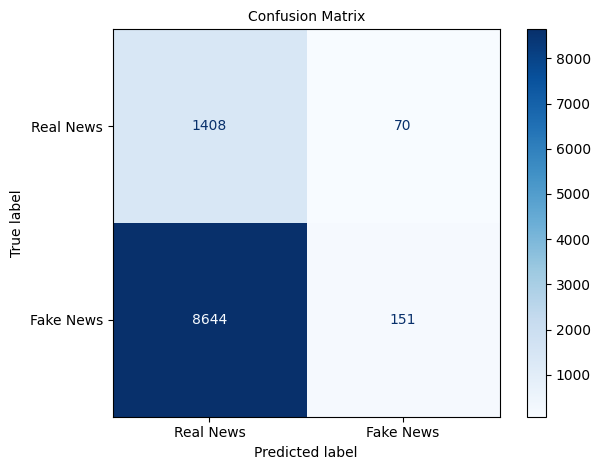

In [11]:
y_pred = model.predict(X_test_emb)
evaluate_model(y_test=y_test, y_pred=y_pred)

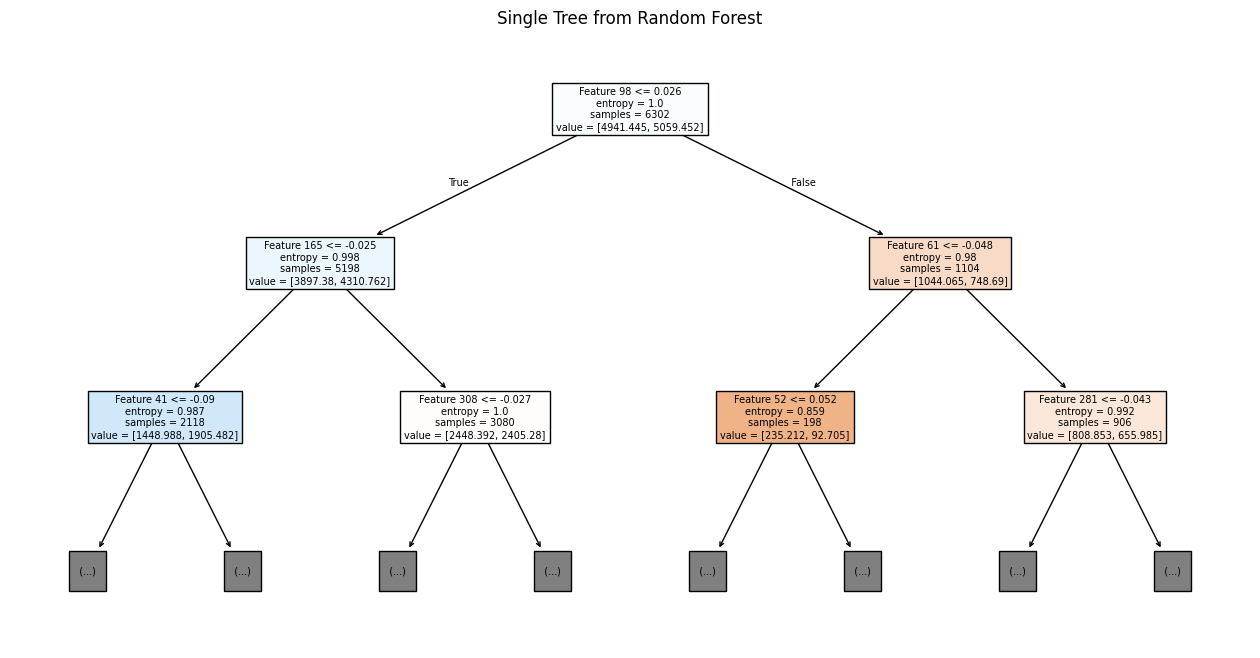

In [17]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Pick one tree from the forest
estimator = model.estimators_[0]
feature_names = [f"Feature {i}" for i in range(X_train_emb.shape[1])]

# Plot the tree
plt.figure(figsize=(16, 8))
plot_tree(estimator, filled=True, feature_names=feature_names, max_depth=2)
plt.title("Single Tree from Random Forest")
plt.show()